## Part 2. Multiview Stereo
* SIFT Feautures matching using RANSAC
* Fundamental, essential matrix estimation
* Homography estimation
* Depth calculation

Read and undistort input images using the parameters found during calibration:

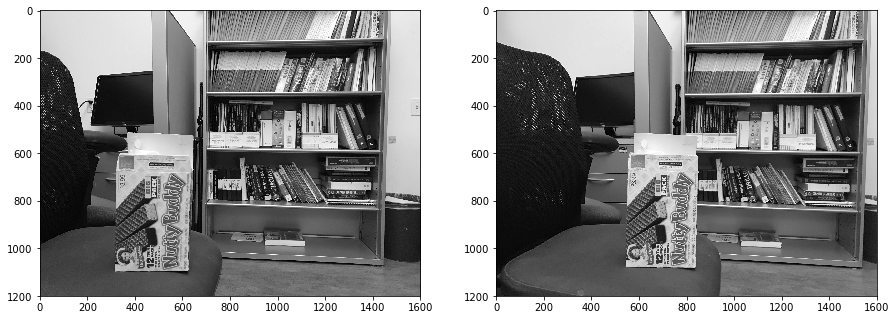

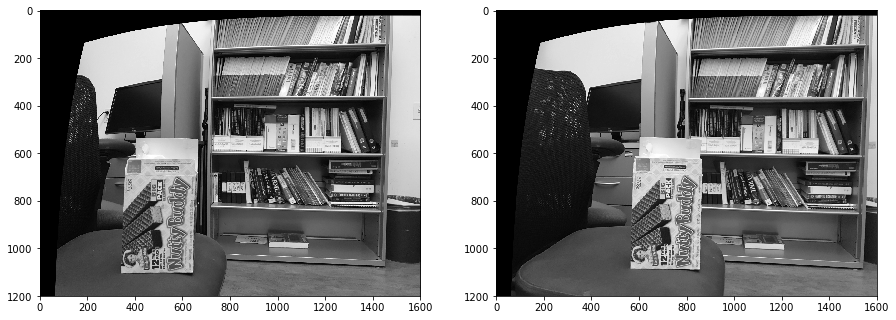

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img01 = cv2.imread('./StereoImages/01.jpeg',0)  #queryimage # left image
img02 = cv2.imread('./StereoImages/02.jpeg',0) #trainimage # right image

plt.figure(figsize=(15,15))
plt.subplot(121),plt.imshow(img01,cmap="gray")
plt.subplot(122),plt.imshow(img02,cmap="gray")
plt.show()

mtx = np.array([[3.27894981e+03, 0.00000000e+00, 2.05358222e+03],
 [0.00000000e+00, 3.29320263e+03, 1.49021929e+03],
 [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

dist = np.array([[ 2.83092458e-01, -1.66799155e+00, -1.62644698e-03,  4.04708463e-04, 3.04420786e+00]])

h, w = img01.shape[:2]
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),0,(w,h))

# undistort
img1 = cv2.undistort(img01, mtx, dist, None, mtx)
img2 = cv2.undistort(img02, mtx, dist, None, mtx)
     
plt.figure(figsize=(15,15))
plt.subplot(121),plt.imshow(img1,cmap="gray")
plt.subplot(122),plt.imshow(img2,cmap="gray")
plt.show()
    
# # crop the image
# x,y,w,h = roi
# img1 = img1[y:y+h, x:x+w]
# img2 = img2[y:y+h, x:x+w]
# cv2.imwrite('./UndistImgs/undist01.jpeg',img1)
# cv2.imwrite('./UndistImgs/undist01.jpeg',img2)

### Feature matching:
We need to find as many possible matches between two images to find the fundamental matrix. For this, we use SIFT descriptors with FLANN based matcher and ratio test:

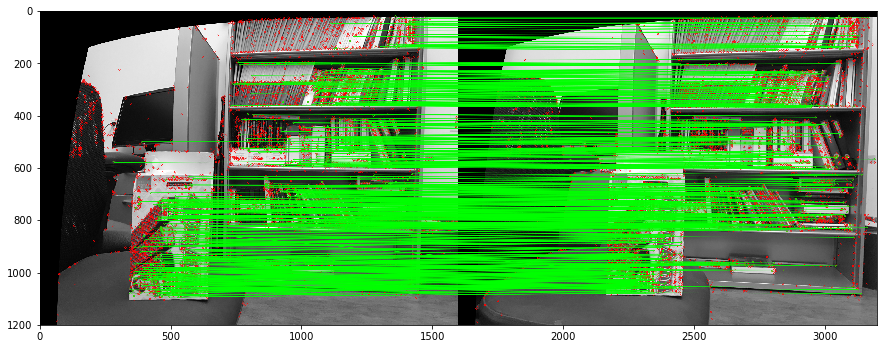

(<matplotlib.image.AxesImage at 0x11fb20e50>, None)

In [2]:
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in xrange(len(matches))]
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.3*n.distance:
        matchesMask[i]=[1,0]
        
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = 0)
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)
plt.figure(figsize=(15,15))
plt.imshow(img3,),plt.show()

### Fundamental Matrix

Now we have the list of best matches from both the images. Let’s find the Fundamental Matrix

In [3]:
good = []
pts1 = []
pts2 = []

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

pts1 = np.float32(pts1)
pts2 = np.float32(pts2)
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)

# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

print 'F = :', F

F = : [[ 4.46473920e-08 -1.00083841e-05 -1.14712559e-03]
 [ 1.12085563e-05 -2.87538608e-07 -1.07933301e-01]
 [ 6.98916194e-04  1.07845045e-01  1.00000000e+00]]


### Epilines

Next we find the epilines. Epilines corresponding to the points in first image is drawn on second image. So mentioning of correct images are important here. We get an array of lines. So we define a new function to draw these lines on the images.

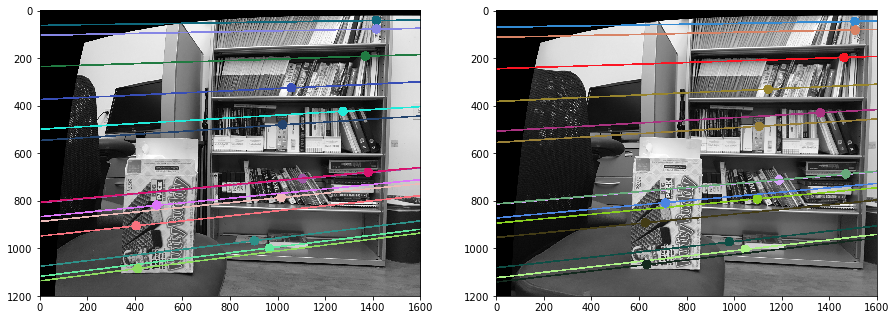

In [4]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, thickness=5, lineType=8)
        img1 = cv2.circle(img1,tuple(pt1),20,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),20,color,-1)
    return img1,img2

# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1[1:-1:200],pts1[1:-1:200],pts2[1:-1:200])

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2[1:-1:200],pts2[1:-1:200],pts1[1:-1:200])

plt.figure(figsize=(15,15))
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

### Compute the essential matrix E:

In [5]:
# Normalize for Esential Matrix calaculation
# pts_l_norm = cv2.undistort(np.expand_dims(pts1, axis=1), cameraMatrix=mtx, distCoeffs=None)
# pts_r_norm = cv2.undistort(np.expand_dims(pts2, axis=1), cameraMatrix=mtx, distCoeffs=None)

pts_l = pts1; pts_r = pts2
pts_l_norm = pts1; pts_r_norm = pts2
K_l = mtx
K_r = mtx

E, mask = cv2.findEssentialMat(pts_l_norm, pts_r_norm, mtx)

print 'E = :', E

E = : [[ 0.0012997  -0.25979201 -0.1123907 ]
 [ 0.30396924 -0.00688388 -0.62843314]
 [ 0.12823114  0.64497002  0.00850391]]


### Compute rotation matrix $R_L^R$ and translation vector $r_R$ (from left to right) :

* Decompose the essential matrix into $R$ and $r$ using decomposeEssentialMat()

* This gives us two rotation matrices $(R_1, R_2)$ and one translation vector $r$ 

$\rightarrow$ There are four possible solutions $(R_1, r)$, $(R_1, -r)$, $(R_2, r)$ and $(R_2, -r)$ 

* We have to disambiguate the solution using triangulation

* Calculate the depth using each pair of $(R, r)$. The one which gives positive $z$ for all the feature points is the correct camera pose $(𝑅_L^𝑅,r_R)$.

In [6]:
R1,R2,t = cv2.decomposeEssentialMat(E)
#print R1
#print R2, t
M_r1 = np.hstack((R2, t))
M_r2 = np.hstack((R1, t))
M_r3 = np.hstack((R2, t*(-1)))
M_r4 = np.hstack((R1, t*(-1)))
M_l = np.hstack((np.eye(3, 3), np.zeros((3, 1))))

P_l = np.dot(K_l,  M_l)
P_r = np.dot(K_r,  M_r4)

t = t*(-1)
R = R1

pts4d = cv2.triangulatePoints(P_l, P_r, np.array(np.transpose(pts1)), np.array(np.transpose(pts2)))
X_vector = [float(pts4d[0][i])/float(pts4d[3][i]) for i in range(len(pts4d[0])) if pts4d[3][i]!=0]
Y_vector = [float(pts4d[1][i])/float(pts4d[3][i]) for i in range(len(pts4d[0])) if pts4d[3][i]!=0]
Z_vector = [float(pts4d[2][i])/float(pts4d[3][i]) for i in range(len(pts4d[0])) if pts4d[3][i]!=0]
Z_vector = np.array(Z_vector)
print 'z_min = :', Z_vector.min()
pts3D = np.vstack((X_vector,Y_vector,Z_vector))

proj_pt3D = np.matmul(mtx, pts3D)

print 'R = :', R
print 't = :', t

z_min = : 8.77596609398044
R = : [[ 9.97287620e-01 -2.49650851e-02  6.92397867e-02]
 [ 2.49476668e-02  9.99688135e-01  1.11641118e-03]
 [-6.92460646e-02  6.13988086e-04  9.97599421e-01]]
t = : [[-0.91637848]
 [ 0.15891575]
 [-0.36741839]]


### Re-projected points
Re-projecting the 3-D points of interest we found onto the first image and showing them. If depth was computed correctly, they should re-project exactly on the same position as the original features. In here the projected points is in red color, the original points is in green color

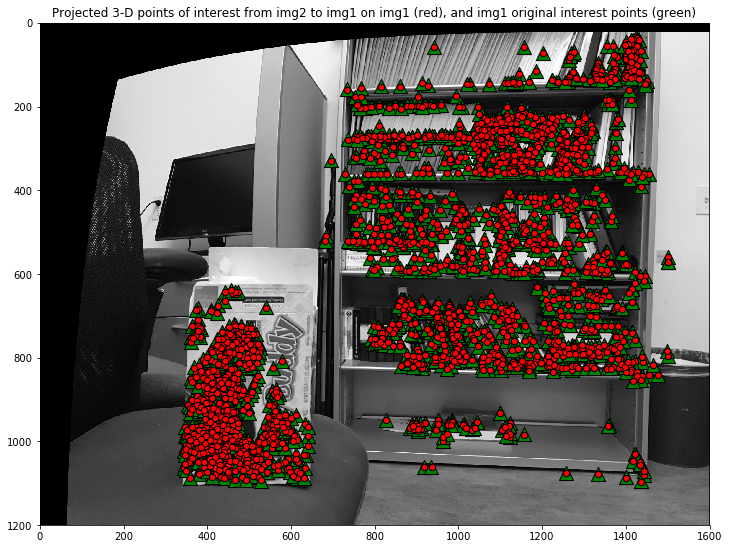

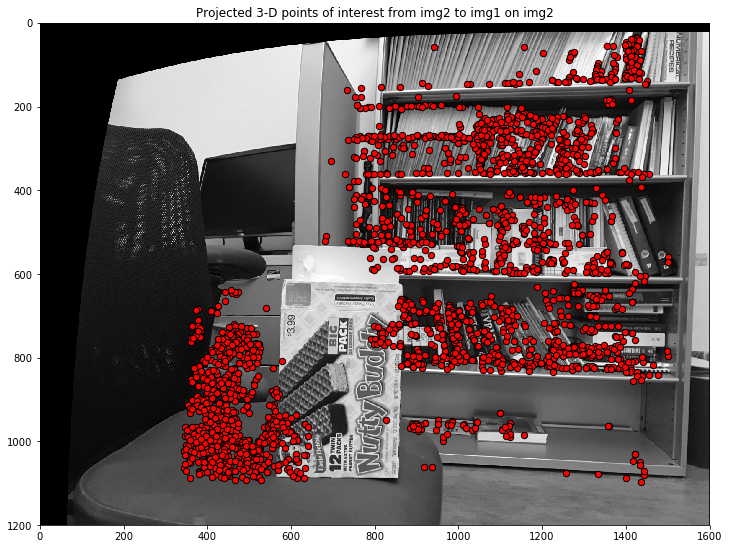

In [7]:
x_vector = [float(proj_pt3D[0][i])/float(proj_pt3D[2][i]) for i in range(len(proj_pt3D[0])) if proj_pt3D[2][i]!=0]
y_vector = [float(proj_pt3D[1][i])/float(proj_pt3D[2][i]) for i in range(len(proj_pt3D[0])) if proj_pt3D[2][i]!=0]
proj_pt3D = np.vstack((x_vector,y_vector))

plt.figure(figsize=(12,12))
plt.title('Projected 3-D points of interest from img2 to img1 on img1 (red), and img1 original interest points (green)')
plt.imshow(img1,cmap="gray")
plt.scatter(x_vector, y_vector, s=200 , marker='^', c = 'g', edgecolors= 'black')
plt.scatter(pts1[:,0], pts1[:,1], s=40, marker='o', c = 'r', edgecolors= 'black')
plt.show()

plt.figure(figsize=(12,12))
plt.title('Projected 3-D points of interest from img2 to img1 on img2')
plt.imshow(img2,cmap="gray")
plt.scatter(pts1[:,0], pts1[:,1], s=40, marker='o', c = 'r', edgecolors= 'black')
plt.show()

### Plane-sweeping stereo

Select a set of planes ${n_L,d_i}$ defined in the reference frame of the first camera, such that the planes are all orthogonal to the first camera’s optical axis (use $n_L=(0,0,−1)$). Choose a set of $N=20$ equispaced distances ${d_i}$ spanning the interval between the minimum $𝑑_{𝑚𝑖𝑛}$ and the maximum $𝑑_{𝑚𝑎𝑥}$ depths that we found after we triangulated the feature points.

For each plane $(n_L,d_i)$:
* Find the homography that warps the second image in the pair such that any point belonging to that plane projects onto the same pixel in the two images (the first image and the warped second image)
* Warp the second image using this homography using the function warpPerspective() 
* Compute the pixel-by-pixel absolute difference between the warped second image and the first image.
* Run a block filter size 15x15 pixels
* At this point we will have $N=20$ images that represent the block-filtered differences. For each pixel (x,y), you should find the index i (corresponding to a plane with distance $𝑑_𝑖$) that gives the lowest value of the block difference

z_max = : 58.15069955431232
z_min = : 8.77596609398044
interval = : 2.4687366730165943 

Plane 0 :
Homography matrix:
[[ 9.53919317e-01 -2.44741654e-02 -7.51548030e+01]
 [-6.41488902e-03  9.99965973e-01  1.05667463e+01]
 [-2.11183667e-05  1.86441029e-07  9.98823453e-01]]


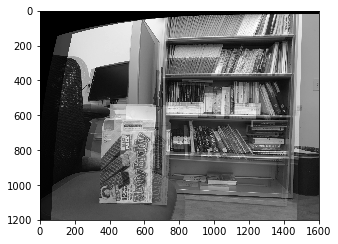

Plane 1 :
Homography matrix:
[[ 9.53919317e-01 -2.44741654e-02  2.27093671e+01]
 [-6.41488902e-03  9.99965973e-01  1.11965340e+01]
 [-2.11183667e-05  1.86441029e-07  1.00838833e+00]]


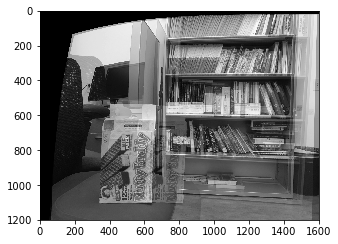

Plane 2 :
Homography matrix:
[[ 9.53919317e-01 -2.44741654e-02  8.41731761e+01]
 [-6.41488902e-03  9.99965973e-01  1.15920735e+01]
 [-2.11183667e-05  1.86441029e-07  1.01439558e+00]]


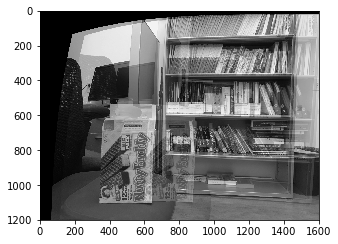

Plane 3 :
Homography matrix:
[[ 9.53919317e-01 -2.44741654e-02  1.26360568e+02]
 [-6.41488902e-03  9.99965973e-01  1.18635631e+01]
 [-2.11183667e-05  1.86441029e-07  1.01851882e+00]]


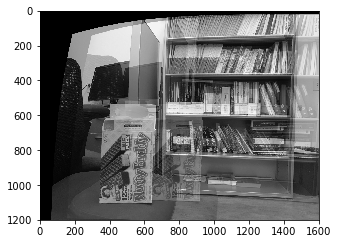

Plane 4 :
Homography matrix:
[[ 9.53919317e-01 -2.44741654e-02  1.57110566e+02]
 [-6.41488902e-03  9.99965973e-01  1.20614493e+01]
 [-2.11183667e-05  1.86441029e-07  1.02152421e+00]]


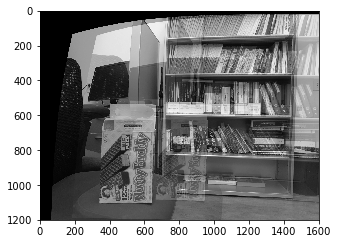

Plane 5 :
Homography matrix:
[[ 9.53919317e-01 -2.44741654e-02  1.80519121e+02]
 [-6.41488902e-03  9.99965973e-01  1.22120909e+01]
 [-2.11183667e-05  1.86441029e-07  1.02381208e+00]]


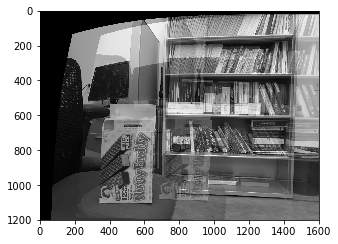

Plane 6 :
Homography matrix:
[[ 9.53919317e-01 -2.44741654e-02  1.98934969e+02]
 [-6.41488902e-03  9.99965973e-01  1.23306029e+01]
 [-2.11183667e-05  1.86441029e-07  1.02561197e+00]]


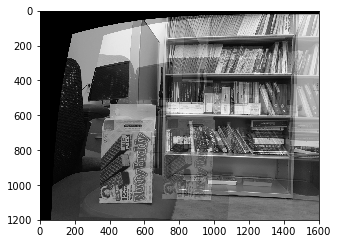

Plane 7 :
Homography matrix:
[[ 9.53919317e-01 -2.44741654e-02  2.13801491e+02]
 [-6.41488902e-03  9.99965973e-01  1.24262738e+01]
 [-2.11183667e-05  1.86441029e-07  1.02706497e+00]]


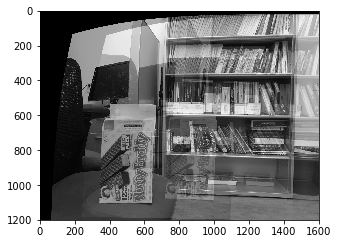

Plane 8 :
Homography matrix:
[[ 9.53919317e-01 -2.44741654e-02  2.26054602e+02]
 [-6.41488902e-03  9.99965973e-01  1.25051265e+01]
 [-2.11183667e-05  1.86441029e-07  1.02826255e+00]]


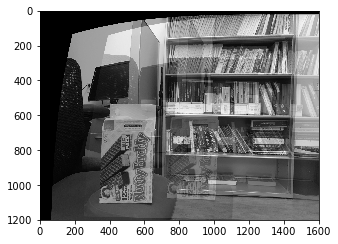

Plane 9 :
Homography matrix:
[[ 9.53919317e-01 -2.44741654e-02  2.36327748e+02]
 [-6.41488902e-03  9.99965973e-01  1.25712375e+01]
 [-2.11183667e-05  1.86441029e-07  1.02926660e+00]]


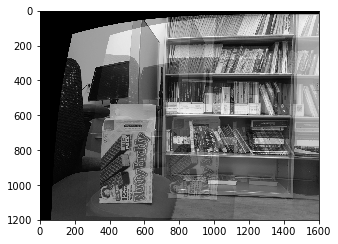

Plane 10 :
Homography matrix:
[[ 9.53919317e-01 -2.44741654e-02  2.45064963e+02]
 [-6.41488902e-03  9.99965973e-01  1.26274643e+01]
 [-2.11183667e-05  1.86441029e-07  1.03012055e+00]]


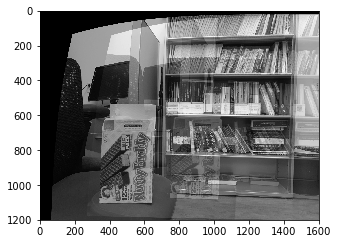

Plane 11 :
Homography matrix:
[[ 9.53919317e-01 -2.44741654e-02  2.52586744e+02]
 [-6.41488902e-03  9.99965973e-01  1.26758694e+01]
 [-2.11183667e-05  1.86441029e-07  1.03085570e+00]]


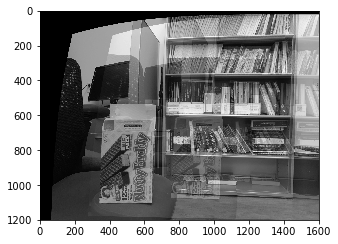

Plane 12 :
Homography matrix:
[[ 9.53919317e-01 -2.44741654e-02  2.59130215e+02]
 [-6.41488902e-03  9.99965973e-01  1.27179788e+01]
 [-2.11183667e-05  1.86441029e-07  1.03149523e+00]]


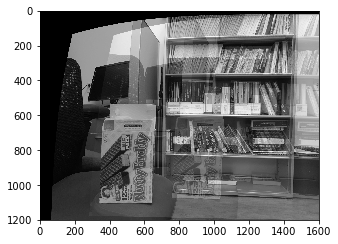

Plane 13 :
Homography matrix:
[[ 9.53919317e-01 -2.44741654e-02  2.64874586e+02]
 [-6.41488902e-03  9.99965973e-01  1.27549457e+01]
 [-2.11183667e-05  1.86441029e-07  1.03205667e+00]]


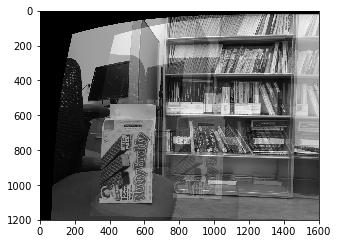

Plane 14 :
Homography matrix:
[[ 9.53919317e-01 -2.44741654e-02  2.69957814e+02]
 [-6.41488902e-03  9.99965973e-01  1.27876579e+01]
 [-2.11183667e-05  1.86441029e-07  1.03255348e+00]]


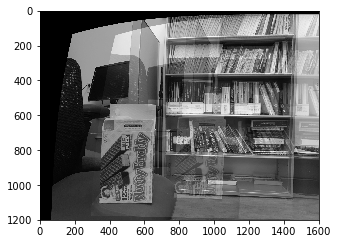

Plane 15 :
Homography matrix:
[[ 9.53919317e-01 -2.44741654e-02  2.74487829e+02]
 [-6.41488902e-03  9.99965973e-01  1.28168100e+01]
 [-2.11183667e-05  1.86441029e-07  1.03299623e+00]]


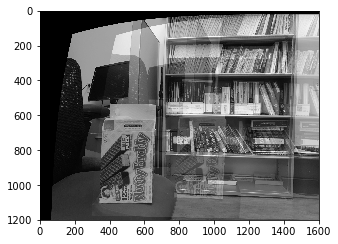

Plane 16 :
Homography matrix:
[[ 9.53919317e-01 -2.44741654e-02  2.78550280e+02]
 [-6.41488902e-03  9.99965973e-01  1.28429532e+01]
 [-2.11183667e-05  1.86441029e-07  1.03339328e+00]]


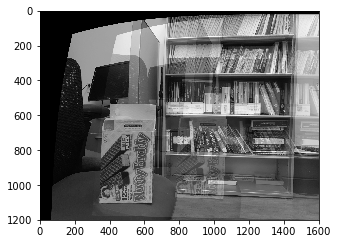

Plane 17 :
Homography matrix:
[[ 9.53919317e-01 -2.44741654e-02  2.82214004e+02]
 [-6.41488902e-03  9.99965973e-01  1.28665304e+01]
 [-2.11183667e-05  1.86441029e-07  1.03375136e+00]]


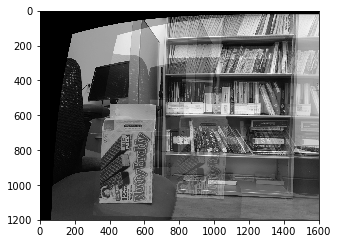

Plane 18 :
Homography matrix:
[[ 9.53919317e-01 -2.44741654e-02  2.85534957e+02]
 [-6.41488902e-03  9.99965973e-01  1.28879019e+01]
 [-2.11183667e-05  1.86441029e-07  1.03407593e+00]]


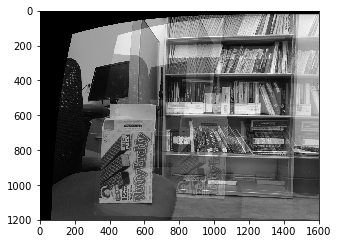

Plane 19 :
Homography matrix:
[[ 9.53919317e-01 -2.44741654e-02  2.88559092e+02]
 [-6.41488902e-03  9.99965973e-01  1.29073631e+01]
 [-2.11183667e-05  1.86441029e-07  1.03437150e+00]]


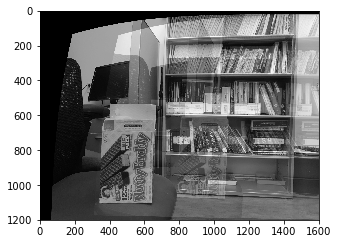

In [8]:
zmax = Z_vector.max()
zmin = Z_vector.min()
interval = (zmax - zmin)/20
print 'z_max = :', zmax
print 'z_min = :', zmin
print 'interval = :', interval, '\n'

d = np.linspace(zmin,zmax,20)

boxstack = np.empty((np.shape(img1)[0],np.shape(img1)[1],20))
for i in range(20):
    n = np.array([[0,0,-1]])
    H = R - np.dot(t,n)/d[i]
    M = np.matmul(mtx,np.matmul(H,np.linalg.inv(mtx)))
    warp = cv2.warpPerspective(img2, M, (img1.shape[1],  img1.shape[0]))
#                                , dst=img1.copy()), borderMode=cv2.BORDER_TRANSPARENT)
    diff = cv2.absdiff(img1, warp)
    box = cv2.blur(diff,(15,15))
    overlay = cv2.addWeighted(img1, 0.7, warp, 0.3, 0)
    print 'Plane',i,':'
    print 'Homography matrix:\n',M
    plt.figure(figsize=(5,5))
    plt.imshow(overlay,cmap="gray")
    plt.show()
#     plt.figure(figsize=(5,5))
#     plt.imshow(box,cmap="gray")
#     plt.show()
    
    boxstack[:,:,i] = box

### Depth image
After we assign a depth for each pixel, we can display the computed depth image. Here white pixels correspond to $𝑑_{𝑚𝑎𝑥}$, while black pixels correspond to $𝑑_{𝑚𝑖𝑛}$

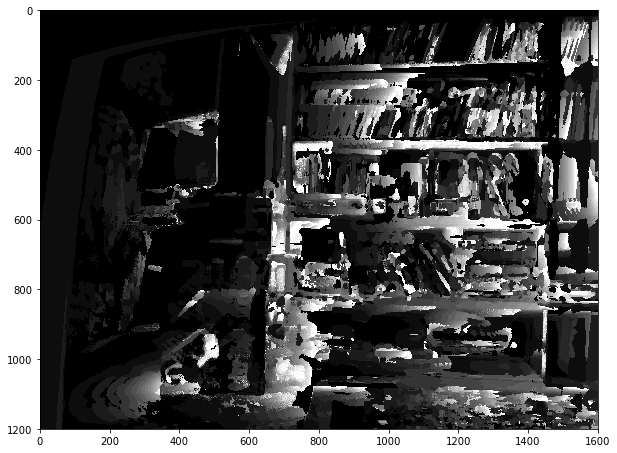

In [9]:
depth_index = np.argmin(boxstack, axis=2)
depth = np.uint8((zmin + depth_index*interval)*255/zmax)
plt.figure(figsize=(10,10))
plt.imshow(depth,cmap="gray")
plt.show()